In [30]:
cd /home/roberto/Desktop/romain_ic/wavemixing_project/py

/home/roberto/Desktop/romain_ic/wavemixing_project/py


In [49]:
import os
import sys

sys.path.insert(0, os.path.abspath("../post_processing/local_calculations"))
sys.path.insert(0, os.path.abspath("../helper_functions/cloud"))
sys.path.insert(0, os.path.abspath("../plots"))
sys.path.insert(0, os.path.abspath("../hamiltonean_builder"))
sys.path.insert(0, os.path.abspath("../correlation"))
sys.path.insert(0, os.path.abspath("../single_and_double_excitations_subspace"))

In [50]:
from qutip import *
import matplotlib.pyplot as plt

from hamiltonean_builder.hamiltonean_builder import *
from helper_functions.operators import *
from plots.multi_plots import *
from correlation.second_order_correlation  import *
from single_and_double_excitations_subspace.parameter_generator_for_ODE import *
from single_and_double_excitations_subspace.atomic_contributions_ODE import *
from post_processing.local_calculations import *
from helper_functions.cloud import *

In [51]:
def column(matrix, i, triD = False, j = 0):
    if triD != False:
        z_column = np.zeros(len(matrix))
        for z in range(len(matrix)):
            z_column[z] = matrix[z][i][j]
        return z_column  
    
    return [row[i] for row in matrix]

In [52]:
ind = 24
position_1_path = f"./benchmarking/N6_Omega0.05_Delta0.0_b0_0.1_S_Int_On_testeODE_t01_direct//positions/positions_N6_Omega0.05_Delta0.0_run{ind}.dat"
rho_1_path = f"./benchmarking/N6_Omega0.05_Delta0.0_b0_0.1_S_Int_On_testeODE_t01_direct//N6_Omega0.05_Delta0.0_run{ind}.npy"

In [35]:
r =  get_positions_from_a_file(position_1_path)

#Hdims = [[2 for i in range(len(r))], [2 for i in range(len(r))]]
#rho = Qobj(file_data_read(rho_1_path), dims=Hdims)


In [36]:
r

[array([-2.76904965,  0.97766517,  6.1633743 ]),
 array([-7.19903166,  6.06106757, -3.45366361]),
 array([ 2.19040425,  3.59886625, -7.77415361]),
 array([-4.21534736,  4.76266059,  5.34850718]),
 array([ 4.21442799, -0.42839247, -5.51785005]),
 array([ 1.51116377, -8.04417159, -7.03649104])]

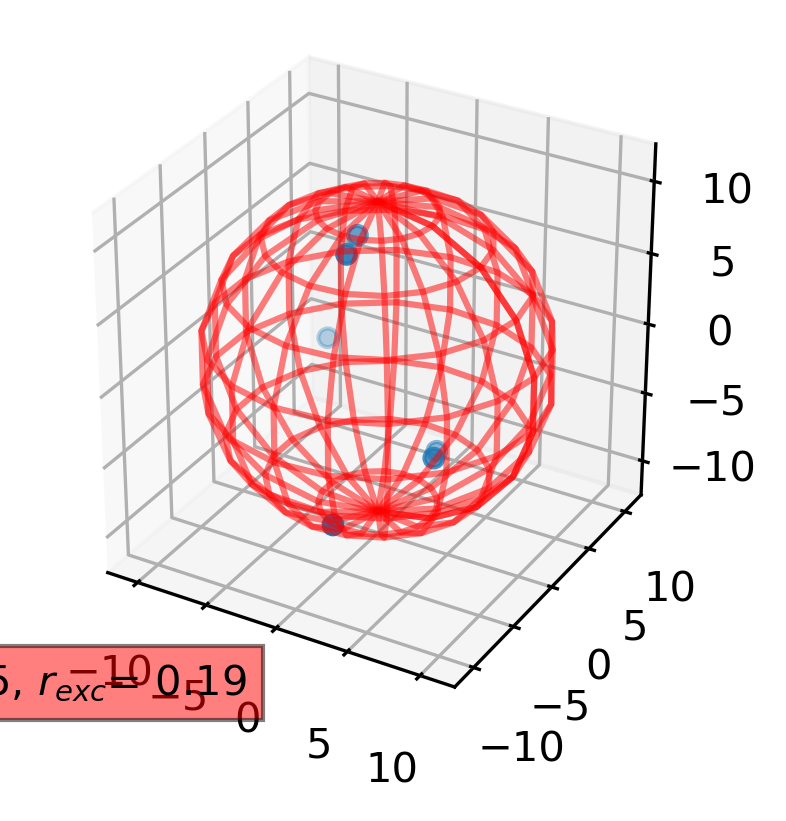

In [85]:
fig = plt.figure(figsize=(4, 3), dpi=300)


ax = fig.add_subplot(projection='3d')
ax.set_aspect("auto")



u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
radius = get_radius_from_optical_thickness(len(r),0.1)
exclusion_radius = get_exclusion_radius_from_optical_thickness(len(r), 1)

x = radius*np.cos(u)*np.sin(v)
y = radius*np.sin(u)*np.sin(v)
z = radius*np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.5)


Xcomponents = column(r, 0, triD = False, j = 0)
Ycomponents = column(r, 1, triD = False, j = 0)
Zcomponents = column(r, 2, triD = False, j = 0)

ax.scatter(Xcomponents, Ycomponents, Zcomponents)


ax.text(0, 0, 10, f'$r$ = {np.round(radius, 2)}, ' + r'$r_{exc} $= '+ f'{np.round(exclusion_radius,2)}',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,  bbox=dict(facecolor='red', alpha=0.5))



world_limits = ax.get_w_lims()
ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],world_limits[5]-world_limits[4]))


### Subspace solutions

In [8]:
b0 = 0.1
N_atoms = len(r)
tf = 50
Omega = 0.05
Delta = 0
t_span, dt = np.linspace(0,tf,100, retstep = True) 

In [9]:
Delta1D, Omega1D, Gamma2D, Delta2D  = GetAllODEParametersGiven_r(Omega, Delta, r, scalar = True)

In [10]:
Beta1D_time_list, Beta2D_time_list, t_span, r = SolveForBeta1DandBeta2D(N_atoms, kd = None, b0 = None, exc_radius = None, Delta = Delta, Omega = Omega, wave_mixing = True, scalar = True, interaction = True, r = r, t_span = t_span  );

### Exact solutions Vector

In [11]:
%timeit
V_H, V_c_ops, GTensor,M, GammaSR, DeltaSR, Omega, SR_state, r = system_spec_N(1, N_atoms, kd = None, b0 = None, exc_radius = None , Delta = Delta, Omega = Omega, wave_mixing = True, scalar = False, r = r)
rho_ss_V, total_time_ss = get_steadystate(V_H, 0, r,  0, V_c_ops, N_atoms, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)

b0 system None
kd system None


In [12]:
%timeit
S_H, S_c_ops, GTensor,M, GammaSR, DeltaSR, Omega, SR_state, r = system_spec_N(1, N_atoms, kd = None, b0 = None, exc_radius = None , Delta = Delta, Omega = Omega, wave_mixing = True, scalar = True, r = r)
rho_ss_S, total_time_ss = get_steadystate(S_H, 0, r,  0, S_c_ops, N_atoms, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)

b0 system None
kd system None


In [13]:
S_sigmam_i_expectations = np.zeros(len(r), dtype = "object")
S_sigmam_ij_expectations = np.zeros((len(r),len(r)), dtype = "object")

V_sigmam_i_expectations = np.zeros(len(r), dtype = "object")
V_sigmam_ij_expectations = np.zeros((len(r),len(r)), dtype = "object")


for i in range(len(r)):
    S_sigmam_i_expectations[i] = expect(rho_ss_S, sigmam_i(N_atoms, i))
    V_sigmam_i_expectations[i] = expect(rho_ss_V, sigmam_i(N_atoms, i))

    for j in range(len(r)):
        S_sigmam_ij_expectations[i][j] = expect(rho_ss_S, sigmam_i(N_atoms, i)*sigmam_i(N_atoms, j))
        V_sigmam_ij_expectations[i][j] = expect(rho_ss_V, sigmam_i(N_atoms, i)*sigmam_i(N_atoms, j))

        

# Single Excitation $\beta_j = \langle \sigma_j \rangle $

/home/roberto/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/roberto/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/roberto/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/roberto/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/roberto/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/roberto/minic

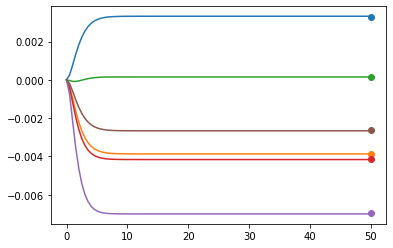

In [14]:
for i in range(len(r)):
    plt.plot(t_span, column(Beta1D_time_list, i))
    plt.scatter(t_span[-1], S_sigmam_i_expectations[i])
    #plt.scatter(t_span[-1], V_sigmam_i_expectations[i])

# Double Excitation $\beta_{ij} = \langle \sigma_i \sigma_j \rangle $

<ipython-input-4-3e91c55e5e6d>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
<ipython-input-4-3e91c55e5e6d>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
<ipython-input-4-3e91c55e5e6d>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
<ipython-input-4-3e91c55e5e6d>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/miniconda3/lib/pytho

<ipython-input-4-3e91c55e5e6d>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
<ipython-input-4-3e91c55e5e6d>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]
/home/roberto/miniconda3/lib/python3.9/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
<ipython-input-4-3e91c55e5e6d>:5: ComplexWarning: Casting complex values to real discards the imaginary part
  z_column[z] = matrix[z][i][j]


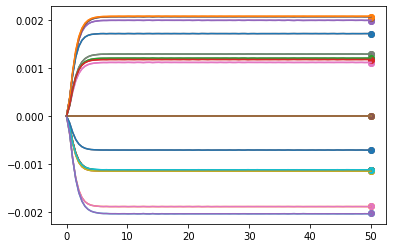

In [15]:
for i in range(len(r)):
    for j in range(len(r)):
        plt.plot(t_span, column(Beta2D_time_list, i, True, j))
        plt.scatter(t_span[-1],(S_sigmam_ij_expectations[i][j]))
        #plt.scatter(t_span[-1],(V_sigmam_ij_expectations[i][j]))

        #plt.ylim(-1,1)
        #plt.xlim(0,0.5)

# Second Correlation Function

In [ ]:
taulist = np.array([0])
nhat = 1


ang1 = 25
R1 = get_nhat_from_angle(ang1)

ang2 = np.linspace(0, 360, 100)
R2_list = [] 
g2_zero_exact = []
g2_zero_approximated = []
V_g2_zero_exact = []


for theta in ang2:
        sys.stdout.write("\r{0}".format(theta))
        sys.stdout.flush()
        
        R2 = get_nhat_from_angle(theta)
        R2_list.append(get_nhat_from_angle(theta))
        
        g2_i = g2_l(S_H, nhat, r, R1, R2, taulist, S_c_ops, N_atoms, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)[0]
        g2_zero_exact.append(g2_i)
        
        g2_i = g2_l(V_H, nhat, r, R1, R2, taulist, V_c_ops, N_atoms, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)[0]        
        V_g2_zero_exact.append(g2_i)
        
        g2_i = np.real(g2_of_zero_subspace_approach(r, R1, R2, Beta1D_time_list[-1], Beta2D_time_list[-1]))
        g2_zero_approximated.append(g2_i)
        


80.0ming on i =  5 

In [ ]:
plt.figure(figsize=(8, 6), dpi=80)

ang2 = np.linspace(0, 360, 100)

plt.plot(ang2, g2_zero_exact,label = "Scalar Exact")
plt.plot(ang2, np.array(g2_zero_approximated)*1/4*4, label = "Scalar Approximated")
#plt.scatter(ang2, V_g2_zero_exact, label = "Vector Exact", marker =  "o", s = 20)


plt.xlabel(r"$\theta$", size = 20)
plt.ylabel(r"$g^{(2)}(0)$", size = 20)
#plt.scatter([25],[2], marker =  "*", label = "Recife (Same direction)")
#plt.scatter([220],[1], marker =  "*", label = "Recife (Opposite direction)")
plt.legend()
#plt.savefig(f"./benchmarking/V_testeODE_t01_negative_N6_b0_0.1_Omega0.05Delta0_pos{ind}.jpg")

In [ ]:
rjhj

taulist = np.array([0])
nhat = 1


ang1 = 25
R1 = get_nhat_from_angle(ang1)

ang2_l = np.linspace(200, 240, 40)
R2_list = [] 
g2_zero_exact = []
g2_zero_approximated = []
G2_zero_approximated = []
normalization_zero_approximated = []


V_g2_zero_exact = []



for theta in ang2_l:
        sys.stdout.write("\r{0}".format(theta))
        sys.stdout.flush()
        
        R2 = get_nhat_from_angle(theta)
        R2_list.append(get_nhat_from_angle(theta))
        
        #g2_i = g2_l(S_H, nhat, r, R1, R2, taulist, S_c_ops, N_atoms, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)[0]
        #g2_zero_exact.append(g2_i)
        
        #g2_i = g2_l(V_H, nhat, r, R1, R2, taulist, V_c_ops, N_atoms, faseglobal = 1, rho_ss = None, rho_ss_parameter = "direct", tmax = None)[0]        
        #V_g2_zero_exact.append(g2_i)
        
        G2, normalization = np.real(g2_of_zero_subspace_approach(r, R1, R2, Beta1D_time_list[-1], Beta2D_time_list[-1],separated = True))
       
        G2_zero_approximated.append(G2)
        normalization_zero_approximated.append(normalization)
        


In [ ]:
plt.plot(ang2, G2_zero_approximated, label = "Numerador")
plt.plot(ang2, normalization_zero_approximated, label = "Denominador")
#plt.plot(ang2, np.array(G2_zero_approximated)/np.array(normalization_zero_approximated))
plt.axvline(ang2[8], G2_zero_approximated[5])
#plt.axhline(0)

plt.legend()

In [ ]:
l = 8
print("numerador = ", G2_zero_approximated[l] , "denominador = " , normalization_zero_approximated[l]) 

In [ ]:
#np.save(f"V_exact_pos{ind}.npy", V_g2_zero_exact )
#np.save(f"S_exact_pos{ind}.npy", g2_zero_exact )
#np.save(f"aproximated_pos{ind}.npy", g2_zero_approximated )